# Installation

conda create -n pyscenic python==3.10
conda activate pyscenic
pip install pyscenic==0.12.1 numpy==1.23.4 distributed==2024.2.1 dask-expr==0.5.3 ipykernel cmake==3.18.4 MulticoreTSNE

At least for aucell, we need pip install pandas==1.5.3 numba==0.56.4

For plotting, we need pip install igraph leidenalg ipywidgets

# Setup

In [1]:
# Basic packages
import loompy as lp
import scanpy as sc
sc.settings.njobs = 32
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
np.object = object
import anndata as ad

# Pyscenic-related
import pyscenic
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2
from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.aucell import aucell
from dask.diagnostics import ProgressBar
from pyscenic.prune import prune2df
from pyscenic.prune import df2regulons

# Plot
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Other
import pickle
import glob
import os
import warnings
warnings.filterwarnings("ignore")

# Modify files

Data were prepared in `Objects_preperations.ipynb`. Motif data were collected from public resources as directed in the pyscenic tutorial. Here, we modify the motif databases to only contain genes in our data as suggested by the authors of pyscenic.

For file download, see:
- https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/
- https://resources.aertslab.org/cistarget/motif2tf/
- https://github.com/aertslab/SCENICprotocol/blob/master/example/allTFs_hg38.txt

In [48]:
adata = ad.read_h5ad("aspc_adi_macro.h5ad")
dff = pd.read_feather("hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather")
dff2 = pd.read_feather("hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather")
dft = pd.read_table("motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl")
tf = pd.read_table("allTFs_hg38.txt", header = None)

In [49]:
dff = dff.loc[:, dff.columns.isin(adata.var.index.append(pd.Index(["motifs"])))]
dff2 = dff2.loc[:, dff2.columns.isin(adata.var.index.append(pd.Index(["motifs"])))]
dft = dft[dft["gene_name"].isin(adata.var.index)]
tf = tf[tf[0].isin(adata.var.index)]
adata = adata[:, adata.var.index.isin(dff2.columns)]
adata

View of AnnData object with n_obs × n_vars = 85121 × 20426
    obs: 'annotation', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [50]:
dff.to_feather("modified_hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather")
dff2.to_feather("modified_hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather")
dft.to_csv("modified_motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl", sep = "\t", index = False)
tf.to_csv("modified_allTFs_hg38.txt", sep = "\t", index = False, header = False)
adata.write_h5ad("modified_aspc_adi_macro.h5ad")

# Create loom file for all cells

In [51]:
adata = ad.read_h5ad("modified_aspc_adi_macro.h5ad")

In [52]:
adata

AnnData object with n_obs × n_vars = 85121 × 20426
    obs: 'annotation', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [53]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs['n_genes'] < 4000, :]

In [54]:
adata

View of AnnData object with n_obs × n_vars = 83407 × 19565
    obs: 'annotation', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells'
    obsm: 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [55]:
row_attrs = { 
    "Gene": np.array(adata.var.index) ,
}
col_attrs = { 
    "CellID":  np.array(adata.obs.index) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}

lp.create("aspc_adi_macro.loom", adata.X.transpose(), row_attrs, col_attrs)

# Run pyscenic CLI

! GRN inference

pyscenic grn \
aspc_adi_macro.loom \
modified_allTFs_hg38.txt \
aspc_adi_macro_adj.csv \
-m grnboost2 \
--num_workers 64

! Regulon prediction

pyscenic ctx \
aspc_adi_macro_adj.csv \
modified_hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather modified_hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather \
--annotations_fname modified_motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl \
--expression_mtx_fname aspc_adi_macro.loom \
--output aspc_adi_macro_reg.csv \
--mask_dropouts \
--nes_threshold 3 \ # Standard
--auc_threshold 0.05 \ # Standard
--num_workers 64

In [11]:
# Check auc_threshold, default it 0.05
nGenesDetectedPerCell = np.sum(adata.X>0, axis=1)
percentiles = pd.DataFrame(nGenesDetectedPerCell).quantile([.01, .05, .10, .15, .50, 1])
print(percentiles)

           0
0.01   609.0
0.05   810.0
0.10   972.0
0.15  1105.0
0.50  1808.0
1.00  3999.0


pyscenic aucell \
aspc_adi_macro.loom \
aspc_adi_macro_reg.csv \
aspc_adi_macro_results.loom \
--auc_threshold 0.05 \
--num_workers 64

# Downstream analyses, setup

::: MulticoreTSNE induces error for binarization, so run tSNE BEFORE switching to pyscenic2 which doesn't contain this app ::: 

conda create -y -n pyscenic2 python==3.10
pip install pyscenic==0.12.1 numpy==1.23.4 distributed==2024.2.1 dask-expr==0.5.3 ipykernel cmake==3.18.4 igraph leidenalg ipywidgets anndata matplotlib seaborn scanpy adjustText

In [1]:
# ---
# Change to pyscenic2 virtual environment
# ---

import loompy as lp
import pandas as pd
import anndata as ad
import numpy as np
import scanpy as sc
sc.settings.njobs = 32
import seaborn as sns
np.object = object

from pyscenic.rss import regulon_specificity_scores
from pyscenic.binarization import binarize

# Plot
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
from pyscenic.plotting import plot_rss
from adjustText import adjust_text
import matplotlib as mpl

# Other
import operator as op
import warnings
warnings.filterwarnings("ignore")

# Downstream analyses

## Generate UMAP and tSNE based on the AUC matrix

In [2]:
lf = lp.connect("aspc_adi_macro_results.loom", mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

auc_mtx

OSError: File 'aspc_adi_macro_results.loom' not found

In [62]:
import umap
# UMAP
runUmap = umap.UMAP(n_neighbors=15, min_dist=0.4, metric='correlation', n_jobs = 60, low_memory=False, verbose = True).fit_transform
dr_umap = runUmap(auc_mtx)
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).reset_index().to_feather( "aspc_adi_macro_umap.feather")

UMAP(angular_rp_forest=True, low_memory=False, metric='correlation', min_dist=0.4, n_jobs=60, verbose=True)
Tue Jun 25 13:57:01 2024 Construct fuzzy simplicial set
Tue Jun 25 13:57:01 2024 Finding Nearest Neighbors
Tue Jun 25 13:57:01 2024 Building RP forest with 19 trees
Tue Jun 25 13:57:07 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	 7  /  16
	 8  /  16
	Stopping threshold met -- exiting after 8 iterations
Tue Jun 25 13:57:30 2024 Finished Nearest Neighbor Search
Tue Jun 25 13:57:33 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Jun 25 13:58:15 2024 Finished embedding


In [63]:
# tSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(n_jobs=64)
dr_tsne = tsne.fit_transform(auc_mtx)
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).reset_index().to_feather( "aspc_adi_macro_tsne.feather")

## pySCENIC UMAP

In [6]:
dr_umap = pd.read_feather("aspc_adi_macro_umap.feather")
dr_umap = dr_umap.set_index(dr_umap["index"])[["X","Y"]]

adata = ad.read_h5ad("modified_aspc_adi_macro.h5ad")
cell_list = list(set(adata.obs.index.to_list()) & set(dr_umap.index.to_list()))
adata = adata[cell_list, :]

adata.obsm['X_scenic'] = np.array(dr_umap.reindex(adata.obs.index))

sc.pp.neighbors(adata, n_neighbors=15, use_rep = 'X_scenic')
sc.tl.leiden(adata, resolution=0.05)

adata

AnnData object with n_obs × n_vars = 83407 × 20426
    obs: 'annotation', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'leiden'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'neighbors', 'leiden'
    obsm: 'X_umap', 'X_scenic'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

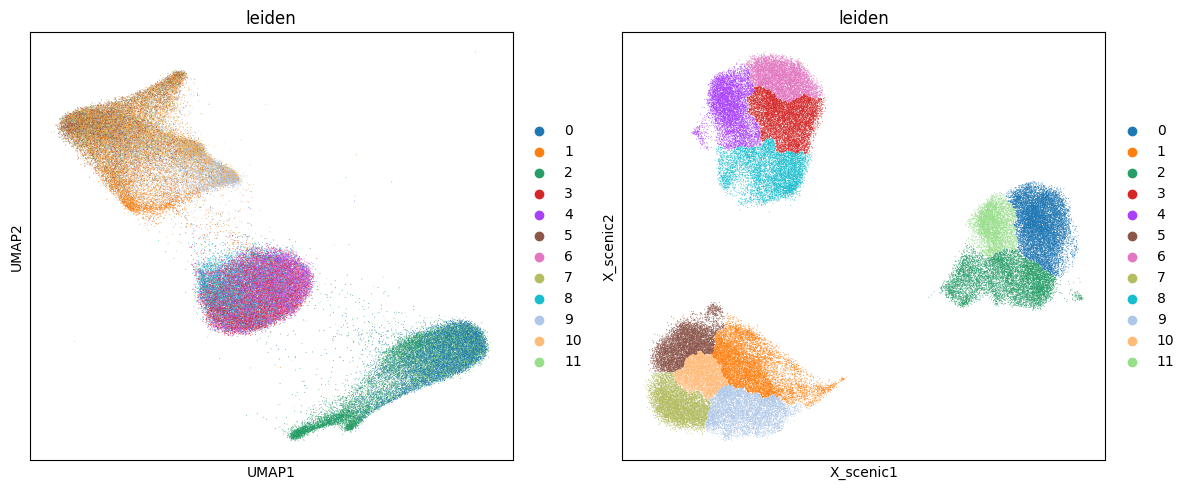

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
p1 = sc.pl.umap(adata, color = ['leiden'], ax = ax1, show = False)
p2 = sc.pl.embedding(adata, 'X_scenic', color = ['leiden'], ax = ax2, show = False)
plt.tight_layout()
plt.show()

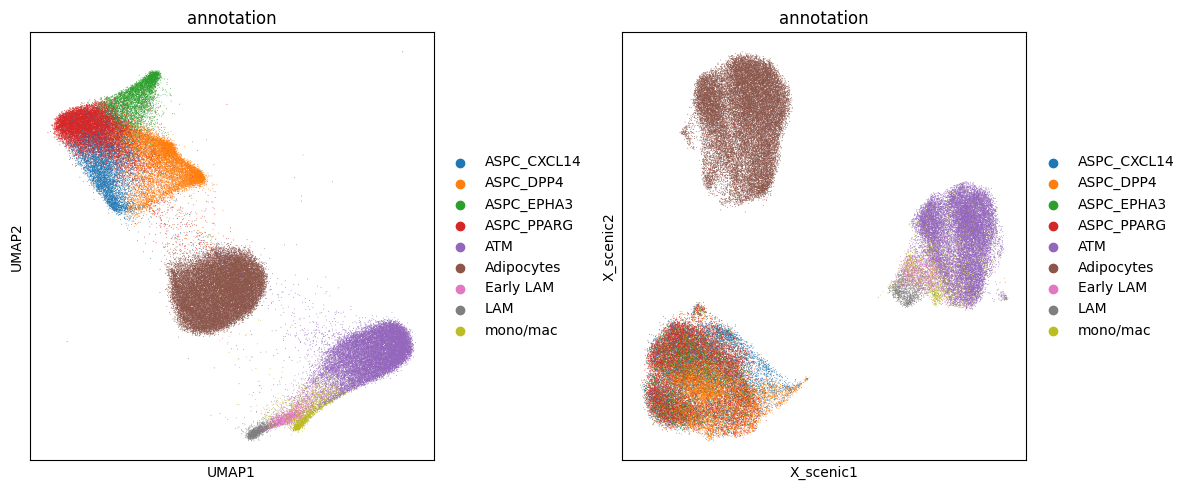

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
p1 = sc.pl.umap(adata, color = ['annotation'], ax = ax1, show = False)
p2 = sc.pl.embedding(adata, 'X_scenic', color = ['annotation'], ax = ax2, show = False)
plt.tight_layout()
plt.show()

## pySCENIC tSNE

In [9]:
dr_tsne = pd.read_feather("aspc_adi_macro_tsne.feather")
dr_tsne = dr_tsne.set_index(dr_tsne["index"])[["X","Y"]]

adata = ad.read_h5ad("modified_aspc_adi_macro.h5ad")
cell_list = list(set(adata.obs.index.to_list()) & set(dr_tsne.index.to_list()))
adata = adata[cell_list, :]

adata.obsm['X_scenic'] = np.array(dr_tsne.reindex(adata.obs.index))

sc.pp.neighbors(adata, n_neighbors=15, use_rep = 'X_scenic')
sc.tl.leiden(adata, resolution=0.05)

adata

AnnData object with n_obs × n_vars = 83407 × 20426
    obs: 'annotation', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'leiden'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'neighbors', 'leiden'
    obsm: 'X_umap', 'X_scenic'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

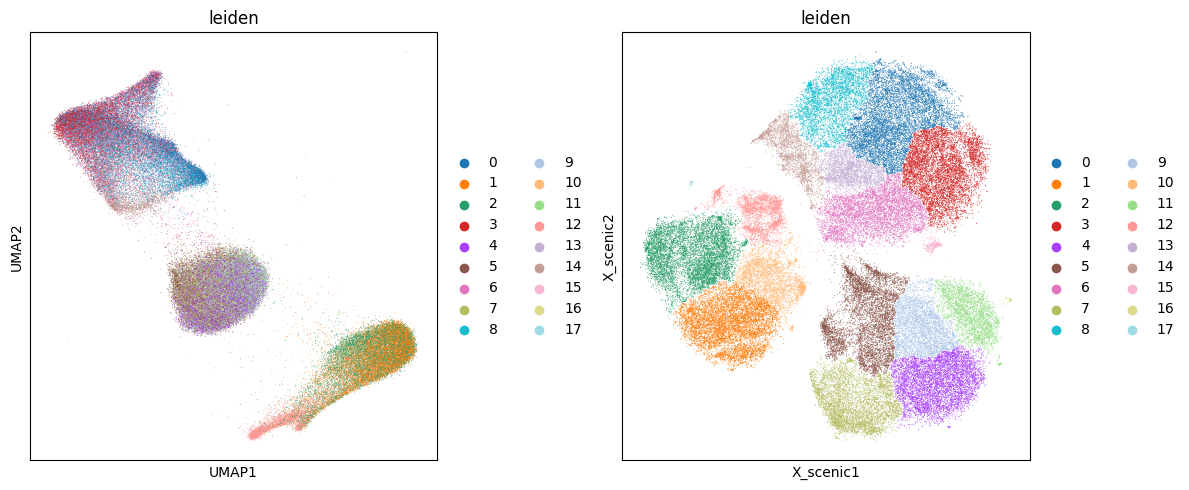

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
p1 = sc.pl.umap(adata, color = ['leiden'], ax = ax1, show = False)
p2 = sc.pl.embedding(adata, 'X_scenic', color = ['leiden'], ax = ax2, show = False)
plt.tight_layout()
plt.show()

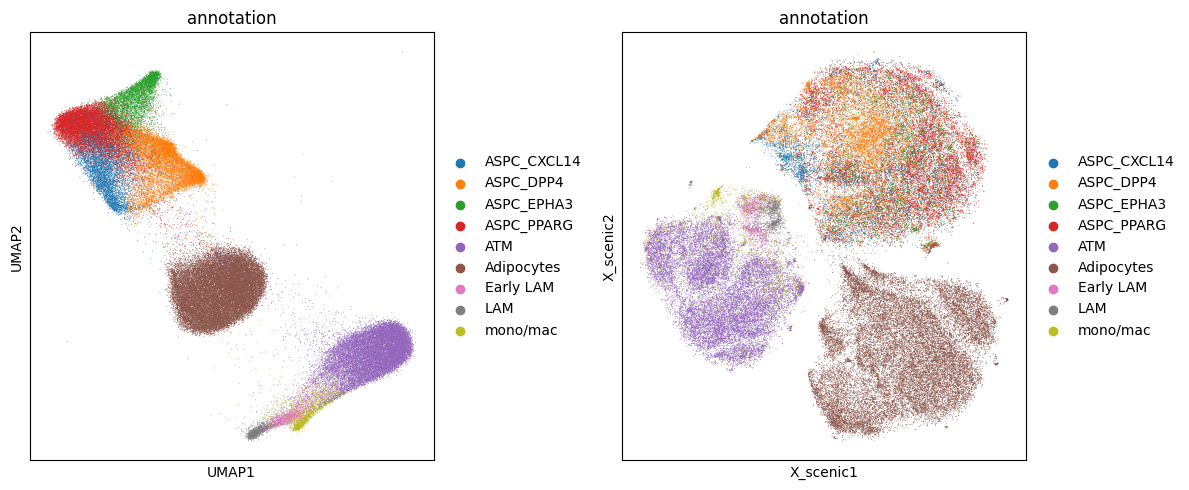

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
p1 = sc.pl.umap(adata, color = ['annotation'], ax = ax1, show = False)
p2 = sc.pl.embedding(adata, 'X_scenic', color = ['annotation'], ax = ax2, show = False)
plt.tight_layout()
plt.show()

## Omit macrophages

In [ ]:
We ran pyscenic on an object including macrophages which we omitted before further downstream analyses.

In [5]:
lf = lp.connect("aspc_adi_macro_results.loom", mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

adata = ad.read_h5ad("modified_aspc_adi_macro.h5ad")

In [6]:
visit = pd.read_csv("all_cells.visits", header = None)

new_idx = []
for string in visit[1]:
    new_idx.append(string.split(sep = "!!", maxsplit = 1)[1])

visit.index = new_idx
visit.index.name = "visit"

visit = visit.reindex(adata.obs.index)
adata.obs["visit"] = visit[0]
adata.obs

,annotation,initial_size_unspliced,initial_size_spliced,initial_size,visit
9975!!ATTCCCGTCCATTCGC-1,ATM,2127,667,667.0,visit1
C748!!TTACTGTGTTCCTACC-1,ASPC_EPHA3,1751,780,780.0,visit1
9986!!ACCTACCAGACGCCCT-1,mono/mac,1765,664,664.0,visit1
9983!!GGGAGTACAGTGTATC-1,ASPC_PPARG,562,330,330.0,visit1
9979!!TTGTTCAAGTGGCGAT-1,ASPC_DPP4,979,426,426.0,visit2
...,...,...,...,...,...
C751!!GTGCTGGTCCAAGCAT-1,ASPC_PPARG,1079,540,540.0,visit3
9978!!CTACCTGCAGAGGACT-1,ASPC_DPP4,3603,913,913.0,visit2
9978!!TTAGGCATCCTTTAGT-1,Early LAM,4438,1110,1110.0,visit2
C746!!GAGACCCGTGGCACTC-1,ASPC_PPARG,676,357,357.0,visit3


In [7]:
anno_vis = []
for anno, vis in zip(adata.obs["annotation"], adata.obs["visit"]):
    anno_vis.append("_".join([anno,vis]))
anno_vis = pd.Categorical(anno_vis).reorder_categories(["ATM_visit1","ATM_visit2","ATM_visit3","mono/mac_visit1","mono/mac_visit2","mono/mac_visit3","Early LAM_visit1","Early LAM_visit2","Early LAM_visit3","LAM_visit1","LAM_visit2","LAM_visit3","ASPC_DPP4_visit1","ASPC_DPP4_visit2","ASPC_DPP4_visit3","ASPC_CXCL14_visit1","ASPC_CXCL14_visit2","ASPC_CXCL14_visit3","ASPC_EPHA3_visit1","ASPC_EPHA3_visit2","ASPC_EPHA3_visit3","ASPC_PPARG_visit1","ASPC_PPARG_visit2","ASPC_PPARG_visit3","Adipocytes_visit1","Adipocytes_visit2","Adipocytes_visit3"])
adata.obs["anno_vis"] = anno_vis
anno_vis

['ATM_visit1', 'ASPC_EPHA3_visit1', 'mono/mac_visit1', 'ASPC_PPARG_visit1', 'ASPC_DPP4_visit2', ..., 'ASPC_PPARG_visit3', 'ASPC_DPP4_visit2', 'Early LAM_visit2', 'ASPC_PPARG_visit3', 'ASPC_PPARG_visit3']
Length: 85121
Categories (27, object): ['ATM_visit1', 'ATM_visit2', 'ATM_visit3', 'mono/mac_visit1', ..., 'ASPC_PPARG_visit3', 'Adipocytes_visit1', 'Adipocytes_visit2', 'Adipocytes_visit3']

In [8]:
cell_list = list(set(adata.obs.index.to_list()) & set(auc_mtx.index.to_list()))
adata = adata[cell_list, :]
adata

View of AnnData object with n_obs × n_vars = 83407 × 20426
    obs: 'annotation', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'visit', 'anno_vis'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [9]:
# Remove macrophages
adata = adata[~adata.obs["annotation"].isin(["ATM","LAM","Early LAM","mono/mac"])]
adata.obs

,annotation,initial_size_unspliced,initial_size_spliced,initial_size,visit,anno_vis
C750!!TCGCAGGCACCTTCCA-1,Adipocytes,7046,2290,2290.0,visit3,Adipocytes_visit3
9973!!TACCGAATCTTGGAAC-1,ASPC_EPHA3,600,400,400.0,visit1,ASPC_EPHA3_visit1
C750!!CATCCCAAGCGTCAAG-1,Adipocytes,4915,1451,1451.0,visit3,Adipocytes_visit3
9975!!CATTCATGTTCTCCTG-1,ASPC_DPP4,2358,1639,1639.0,visit2,ASPC_DPP4_visit2
9973!!GCTACAATCAATCGGT-1,ASPC_CXCL14,694,460,460.0,visit2,ASPC_CXCL14_visit2
...,...,...,...,...,...,...
9985!!AATTTCCGTAGGACCA-1,ASPC_CXCL14,745,621,621.0,visit2,ASPC_CXCL14_visit2
C744!!TCGCTCAGTAATGCGG-1,ASPC_DPP4,4490,1947,1947.0,visit3,ASPC_DPP4_visit3
9972!!GGGAGTAAGCAGAAAG-1,ASPC_DPP4,1641,971,971.0,visit1,ASPC_DPP4_visit1
9975!!GTGTTCCAGTAGGATT-1,Adipocytes,3426,1312,1312.0,visit2,Adipocytes_visit2


In [10]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)

#auc_mat = ad.AnnData(X = auc_mtx_Z.transpose()) # Really not sure why this should be transposed?
auc_mat = ad.AnnData(X = auc_mtx_Z)
auc_mat.obs["anno_vis"] = adata.obs["anno_vis"]

auc_mtx_Z["anno_vis"] = adata.obs["anno_vis"]

mean_auc_by_cell_type = auc_mtx_Z.groupby("anno_vis").mean()

top_n = 50
top_tfs = mean_auc_by_cell_type.max(axis=0).sort_values(ascending=False).head(top_n)
mean_auc_by_cell_type_top_n = mean_auc_by_cell_type[
    [c for c in mean_auc_by_cell_type.columns if c in top_tfs]
]

## Export of data

In [12]:
import fast_matrix_market as fmm

fmm.mmwrite("aspc_adi_auc_mat.mtx", auc_mat.X)
pd.Series(auc_mat.obs.index).to_csv("aspc_adi_auc_mat.rownames", index = False)
pd.Series(auc_mat.var.index).to_csv("aspc_adi_auc_mat.colnames", index = False)

## Figure 4g - Regulon dotplot

In [11]:
reg = ['FOS(+)', 'JUN(+)', 'JUND(+)', 'JUNB(+)']

In [12]:
auc_mat_edit = auc_mat[~auc_mat.obs["anno_vis"].isin(["Adipocytes_visit1","Adipocytes_visit2","Adipocytes_visit3"])]
auc_mat_edit.obs["anno_vis"].cat.categories

Index(['ASPC_DPP4_visit1', 'ASPC_DPP4_visit2', 'ASPC_DPP4_visit3',
       'ASPC_CXCL14_visit1', 'ASPC_CXCL14_visit2', 'ASPC_CXCL14_visit3',
       'ASPC_EPHA3_visit1', 'ASPC_EPHA3_visit2', 'ASPC_EPHA3_visit3',
       'ASPC_PPARG_visit1', 'ASPC_PPARG_visit2', 'ASPC_PPARG_visit3'],
      dtype='object')

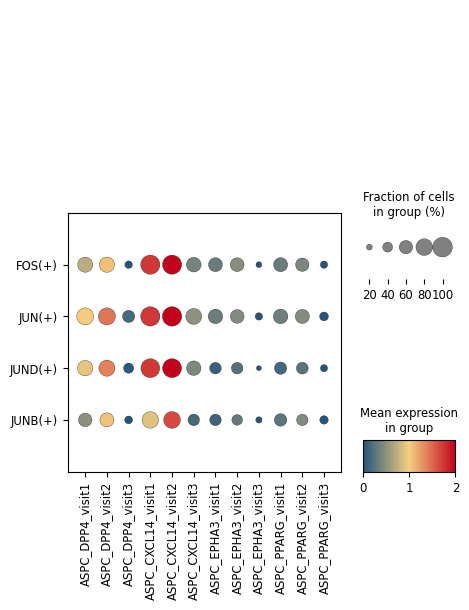

<Figure size 640x480 with 0 Axes>

In [13]:
cmap = LinearSegmentedColormap.from_list('sweet', ['#25557B', '#F4CE80', '#C4031D'])
fig, (ax1) = plt.subplots(1,1, figsize=(5,6))
sc.pl.dotplot(auc_mat_edit, reg, groupby='anno_vis', cmap=cmap, vmin=0, vmax=2, vcenter=1, swap_axes=True, ax=ax1, categories_order = auc_mat_edit.obs["anno_vis"].cat.categories, save = "4g_SCENIC_dotplot.pdf")
plt.tight_layout()